In [2]:
#https://ravivaishnav20.medium.com/visualizing-feature-maps-using-pytorch-12a48cd1e573
import torch
import numpy as np
import os
import sys
sys.path.append('../')
os.environ["CUDA_VISIBLE_DEVICES"]="4"
import torchvision
from voc import *
from coco import *
import torchvision.transforms as transforms
from torchvision.models import resnet152, resnet101, resnet18, resnet34, resnet50
from tqdm import tqdm
import json
import pandas as pd
import matplotlib.pyplot as plt
from config import seed_everything
seed_everything(0)
from models import *
from torchsummary import summary

import torch
import torch.nn as nn
import torchvision
from torchvision import models, transforms, utils
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import scipy.misc
from PIL import Image
import json
%matplotlib inline

In [88]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])
transform = transforms.Compose([
                MultiScaleCrop(224, scales=(1.0, 0.875, 0.75, 0.66, 0.5), max_distort=2),
                transforms.ToTensor(),
                normalize,
            ])

In [89]:

from models import *


m_li = [base_resnet50(80, pretrained=True), base_vit(80, image_size=224, pretrained=True), base_swin(80, image_size=224, pretrained=True)]
# m_li2 = [BaseResnet(m_li[0], 80)]
p_li = ['/home/seongha/LT-ML/checkpoint/coco/coco_LT(0)_label_count_resnet50-4-4-0_resnet50_base_best.pth.tar' ,\
  '/home/seongha/LT-ML/checkpoint/coco/coco_LT(0)_label_count_vit-4-4-0_vit_base_best.pth.tar', \
  '/home/seongha/LT-ML/checkpoint/coco/coco_LT(0)_label_count_swin-4-4-0_swin_base_best.pth.tar', \
  ]

def get_model(index):
  path = p_li[index]
  model = m_li[index]
  di = torch.load(path)
  print(di['best_score'])
  print(di.keys())
  model.load_state_dict(di['state_dict'])
  return model

model = get_model(0)
print(model)
# summary(model.features, (3,224,224), None)

Linear(in_features=768, out_features=80, bias=True)
{'mAP': tensor(62.4261), 'OF1': 0.6323788284730504, 'CF1': 0.5572570761842324}
dict_keys(['epoch', 'arch', 'state_dict', 'best_score'])
BaseResnet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)

In [90]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [73]:
# we will save the conv layer weights in this list
model_weights =[]
#we will save the 49 conv layers in this list
conv_layers = []
# get all the model children as list
model_children = list(model.features.children())
print(model_children)
#counter to keep count of the conv layers
counter = 0
#append all the conv layers and their respective wights to the list
for i in range(len(model_children)):
    # if type(model_children[i]) == nn.Conv2d:
    if type(model_children[i]) == nn.Block:
        counter+=1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                # if type(child) == nn.Conv2d:
                if type(child) == nn.Block:
                    counter+=1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
print(f"Total convolution layers: {counter}")

[PatchEmbed(
  (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (norm): Identity()
), Dropout(p=0.0, inplace=False), Sequential(
  (0): Block(
    (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
    (attn): Attention(
      (qkv): Linear(in_features=768, out_features=2304, bias=True)
      (attn_drop): Dropout(p=0.0, inplace=False)
      (proj): Linear(in_features=768, out_features=768, bias=True)
      (proj_drop): Dropout(p=0.0, inplace=False)
    )
    (ls1): Identity()
    (drop_path1): Identity()
    (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
    (mlp): Mlp(
      (fc1): Linear(in_features=768, out_features=3072, bias=True)
      (act): GELU()
      (drop1): Dropout(p=0.0, inplace=False)
      (fc2): Linear(in_features=3072, out_features=768, bias=True)
      (drop2): Dropout(p=0.0, inplace=False)
    )
    (ls2): Identity()
    (drop_path2): Identity()
  )
  (1): Block(
    (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=

AttributeError: module 'torch.nn' has no attribute 'Block'

Image shape before: torch.Size([3, 224, 224])
Image shape after: torch.Size([1, 3, 224, 224])
0


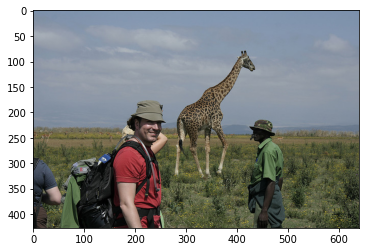

In [98]:
img_li = [{"file_name": "COCO_train2014_000000475804.jpg", "labels": [57, 35, 13]},
{"file_name": "COCO_train2014_000000195525.jpg", "labels": [49, 35, 22]},
 {"file_name": "COCO_train2014_000000249764.jpg", "labels": [49, 35, 22]},

 {"file_name": "COCO_train2014_000000199956.jpg", "labels": [18, 63]},
{"file_name": "COCO_train2014_000000098760.jpg", "labels": [18, 28]},
{"file_name": "COCO_train2014_000000485894.jpg", "labels": [18, 71]},

{"file_name": "COCO_train2014_000000462472.jpg", "labels": [49, 4, 5]}, {"file_name": "COCO_train2014_000000039261.jpg", "labels": [49, 4, 5]}, {"file_name": "COCO_train2014_000000236760.jpg", "labels": [49, 4, 5]},
 {"file_name": "COCO_train2014_000000497261.jpg", "labels": [49, 4, 5]}, {"file_name": "COCO_train2014_000000072969.jpg", "labels": [49, 4, 62]},

{"file_name": "COCO_train2014_000000101418.jpg", "labels": [34]}, {"file_name": "COCO_train2014_000000445528.jpg", "labels": [34]}, {"file_name": "COCO_train2014_000000334080.jpg", "labels": [34]}, {"file_name": "COCO_train2014_000000108627.jpg", "labels": [34]}, {"file_name": "COCO_train2014_000000122108.jpg", "labels": [34]},
{"file_name": "COCO_train2014_000000479712.jpg", "labels": [10, 34, 79]},
{"file_name": "COCO_train2014_000000230559.jpg", "labels": [49, 34, 2]},
]
img_id = '/home/seongha/LT-ML/data/coco/data/train2014/{}'.format(img_li[-1]["file_name"])
image = Image.open(img_id)
plt.imshow(image)
import copy
original_img = copy.copy(image)
image = transform(image)


print(f"Image shape before: {image.shape}")
image = image.unsqueeze(0)
print(f"Image shape after: {image.shape}")
image = image.to(device)
x = torch.clone(image)
print(x.get_device())

In [16]:
outputs = []
names = []
for layer in conv_layers[0:]:
    layer = layer.to(device)
    image = layer(image)
    outputs.append(image)
    names.append(str(layer))
print(len(outputs))
#print feature_maps
for feature_map in outputs:
    print(feature_map.shape)

49
torch.Size([1, 64, 112, 112])
torch.Size([1, 64, 112, 112])
torch.Size([1, 64, 112, 112])
torch.Size([1, 256, 112, 112])
torch.Size([1, 64, 112, 112])
torch.Size([1, 64, 112, 112])
torch.Size([1, 256, 112, 112])
torch.Size([1, 64, 112, 112])
torch.Size([1, 64, 112, 112])
torch.Size([1, 256, 112, 112])
torch.Size([1, 128, 112, 112])
torch.Size([1, 128, 56, 56])
torch.Size([1, 512, 56, 56])
torch.Size([1, 128, 56, 56])
torch.Size([1, 128, 56, 56])
torch.Size([1, 512, 56, 56])
torch.Size([1, 128, 56, 56])
torch.Size([1, 128, 56, 56])
torch.Size([1, 512, 56, 56])
torch.Size([1, 128, 56, 56])
torch.Size([1, 128, 56, 56])
torch.Size([1, 512, 56, 56])
torch.Size([1, 256, 56, 56])
torch.Size([1, 256, 28, 28])
torch.Size([1, 1024, 28, 28])
torch.Size([1, 256, 28, 28])
torch.Size([1, 256, 28, 28])
torch.Size([1, 1024, 28, 28])
torch.Size([1, 256, 28, 28])
torch.Size([1, 256, 28, 28])
torch.Size([1, 1024, 28, 28])
torch.Size([1, 256, 28, 28])
torch.Size([1, 256, 28, 28])
torch.Size([1, 1024, 2

Now convert 3D tensor to 2D, Sum the same element of every channel

In [17]:
processed = []
for feature_map in outputs:
    feature_map = feature_map.squeeze(0)
    gray_scale = torch.sum(feature_map,0)
    gray_scale = gray_scale / feature_map.shape[0]
    processed.append(gray_scale.data.cpu().numpy())
for fm in processed:
    print(fm.shape)

(112, 112)
(112, 112)
(112, 112)
(112, 112)
(112, 112)
(112, 112)
(112, 112)
(112, 112)
(112, 112)
(112, 112)
(112, 112)
(56, 56)
(56, 56)
(56, 56)
(56, 56)
(56, 56)
(56, 56)
(56, 56)
(56, 56)
(56, 56)
(56, 56)
(56, 56)
(56, 56)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
(14, 14)
(14, 14)


In [ ]:
fig = plt.figure(figsize=(30, 50))
for i in range(len(processed)):
    a = fig.add_subplot(20, 3, i+1)
    imgplot = plt.imshow(processed[i])
    a.axis("off")
    a.set_title(names[i].split('(')[0], fontsize=30)
 
a = fig.add_subplot(20, 3, len(processed)+1)
imgplot = plt.imshow(original_img)
a.axis("off")
plt.savefig('../figures/feature_map_{}.jpg'.format(img_li[0]["file_name"]), bbox_inches='tight')